# Clase 6 - NLP - Clasificador
![picture](https://drive.google.com/uc?id=1Ar6KpqlsLxcLlnOrXPx6QZejStP6bV9P)

## Pre requisitos

Se actualiza fastai descargando y ejecutando el script *colab*

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Dar permiso para acceder a mi Drive

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Nos aseguramos que cualquier cambio en una librería es recargado automáticamente y que que cualquier gráfica o imagen se muestre aquí

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importamos las librerías necesarias

In [0]:
from fastai.text import *

## Curso 6 - NLP - Clasificador

Para implementar un clasificador nos basamos en el método descrito en [Jeremy Howard, Sebastian Ruder - Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146), en el que usan transfer learning para implementar un modelo de lenguaje a partir de otro ya existente, y con dicho modelo del lenguaje crear el clasificador

![image](https://rajeethkumardharmaraj.files.wordpress.com/2018/08/ulmfit_pic.jpg?w=736)

En el paper, lo que explican es que a partir de un modelo de lenguaje creado con textos de wikipedia [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)), mediante transfer learning crean otro modelo para el contexto en el que se quiera utilizar, ya que el lenguaje utilizado en wikipedia probablemente no sea el mismo que el usado en foros.
Un modelo de lenguaje consiste en un modelo que predice la siguiente palabra. Los modelos necesitan conocer mucho del lenguaje y del contexto, por eso no es lo mismo un modelo del lenguaje para la wikipedia que para un foro

Cuando ya se tiene el nuevo modelo de lenguaje se crea un clasificador

En nuestro caso queremos hacer un clasificador de críticas de cine. Dado un texto en el que se realiza una crítica de cine se quiere clasificar esta como buena o mala, es decir, si la critica es buena hacia la película o mala


Por ello, primero adaptaremos el modelo del lenguaje de wikipedia al contexto de las críticas de cine. Es decir creamos un modelo de lenguaje para nuestro problema.

En el momento que tennnemos el nuevo modelo del lenguaje podemos hacer el clasificador de críticas de cine

### Descarga del dataset

#### Descarga del dataset simple

Nos descargamos el dataset [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) (Internet Movie Database), que contiene un conjunto de 100.000 críticas de películas, de las cuales 25.000 están etiquetadas como positivas o negativas para entrenamiento, 25.000 etiquetadas para validación y otras 50.000 sin etiquetar para uso de investigación

Descargamos primero el conjunto simple

In [0]:
path_sample = untar_data(URLs.IMDB_SAMPLE)
path_sample.ls()

[PosixPath('/content/data/imdb_sample/texts.csv')]

Colo contiene un archivo `.csv`, vamos a ver qué contiene

In [0]:
df = pd.read_csv(path_sample/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Podemos ver que contiene tres columnas:


*   `label`: etiqueta, criítica positiva o negativa
*   `text`: crítica
*   `is_valid`: si pertenece al conjunto de entrenamiento o validación

Veamos una crítica



In [0]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Si ignoramos la última columna (`is_valid`) podemos crear un dataset mediante DataBunch

In [0]:
data_sample = TextDataBunch.from_csv(path_sample, 'texts.csv')

La función `TextDataBunch` a creado un proceso oculto para que obtengamos el dataset, por lo que pasamos a explicarlo

Cuando procesamos imágenes tenemos un conjunto de píxeles con un valos numérico, con los que podemos realiazr operaciones matemáticas. Sin embargo con las palabras no, por lo que se realizan dos subprocesos

*   Tokenización
*   Numeración

Con estos dos procesos se convierten las palabras a números con los que poder realizar los cálculos matemáticos



##### Tokenización

El primer paso es dividir los textos en tokens, esto lo podemos hacer por ejemplo separando cada vez que encontramos un espacio, pero hay que tener cuidado porque puede haber signos de puntuación, palabras compuestas...

In [0]:
data_sample.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative


Como se puede ver se han dividido los textos en tokens. Por ejemplo se puede ver que _it's_ se ha dividido en _it_ y _'s_. Se ha dividido _didn't_ en _did_ y _n't_.

##### Numerización

A continuación cada token obtenido se combierte a un número, a una ID única. Para controlar el número de tokens se limita este a 60.000, y todos aquellos que aparecen menos de dos veces no se incluyen

Las correspondientes palabras de cada ID es lo que llamamos vocabulario

In [0]:
data_sample.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

Podemos ver que las palabras de nuestro dataset se han transformado a sus correspondientes IDs

In [0]:
data_sample.train_ds[0][0].data[:10]

array([  2,   5,  21,  29,  16,  55,  53, 418,  11,   5])

Todo esto lo podríamos haber hecho con la data block API, que nos ofrece una mayor flexibilidad

In [0]:
data_sample = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

#### Descarga del dataset completo

Descargamos ahora el dataset completo

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

Vemos que hay una carpeta de entrenamiento y otra de validación. Además hay una carpeta (`unsup`) con las reseñas sin cllasificar

Vemos que hay dentro de la carpeta de entrenamiento

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

Dentro vemos que hay una carpeta para las reseñas positivas y otra para las reseñas negativas

### Modelo del lenguaje

#### Se crea el dataset

No vamos a realizar ahora el clasificador, vamos a hacer transfer learning, por lo que cogemos todas las reseñas, las positivas, las negativas y las que están sin clasificar.

Lo que queremos es pasar del modelo basado en la wikipedia a un modelo basado en las reseñas. Es decir, que si se le da parte de una reseña, sepa predecir la siguiente palabra de esta

In [0]:
bs=48

* Como todos los textos están en carpetas se usa `TextList.from_folder` en vez de `TextList.from_csv`
* Se usa `filter_by_folder` para indicar de dónde se obtienen los archivos de texto
* Indicamos el porcentaje de textos que se usarán para validación con `split_by_rand_pct`. Podemos hacer esto porque ahora no necesiitamos las etiquetas, solo conjuntos de texto
* Con `label_for_lm` indicamos que las etiquetas las obtenemos del propio modelo de lenguaje (language model [lm])
* Por último creamos el `DataBunch` con `databunch`

In [0]:
data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

data_lm.save('data_lm.pkl')

Como crear este dataset ha llevado mucho tiempo, podemos guardarlo y cargarlo en el futuro mediante el comando

`data_lm = load_data(path, 'data_lm.pkl', bs=bs)`

In [0]:
data_lm.show_batch()

idx,text
0,"it is people , a well above average action film . i could go on but i 've made my comment . xxbos xxmaj this movie appears to have designed as a xxmaj fred xxmaj astaire - xxmaj ginger xxmaj rogers film -- the plot outline , dance numbers , zippy music and the entire formula is there ... except for xxmaj ginger ! xxmaj whether it xxup really was"
1,is so subtle you do n't know how to read it ! xxmaj are these guys doing a full blown comedy or is there something else going on . xxmaj the little dialogue the film has is n't very delicate and this adds to the power of the film . xxmaj if all the sound was switched off from the film it actually would n't take anything away from the
2,"during xxup wwii , xxmaj bob xxmaj clampett 's "" xxmaj an xxmaj itch in xxmaj time "" portrays a hobo flea settling on xxmaj elmer xxmaj fudd 's dog . xxmaj the little guy turns into a real sadist while making a home on the dog 's back , but xxmaj elmer warns the dog : "" xxmaj one more xxunk and i 'll give you a bath !"
3,". xxmaj he gets the bright idea of torturing xxmaj tom without him knowing . xxmaj the cat gets wise and tries to do stuff to make him ' see ' jerry even if it 's not fool - proof . xxmaj of course xxmaj jerry gets xxmaj butch aka xxmaj killer aka xxmaj spike the dog into the act ( even if it 's late in the short ,"
4,"where sweet asides are actually acceptable ( "" i have to tell you a secret "" , xxmaj jessie says , and then leans in for a kiss , ho - ho ) , or in the little moments that pop up with other people along the way . i loved the scene with the poet , where it 's very cinematic a thing to suddenly find a random romantic"


#### Entrenamiento

Creamos el modelo

El abandono (dropout) es una técnica de las redes neuronales para evitar el sobreentrenamiento

![imagen](https://miro.medium.com/max/1400/1*iWQzxhVlvadk6VAJjsgXgg.png)

Se establece una probabilidad de eliminar las conexiones entre ciertas neuronas

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


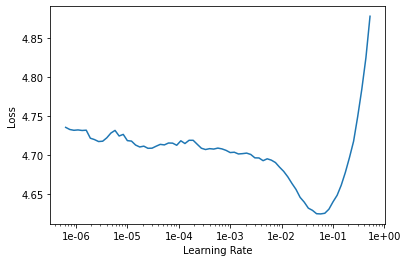

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
lr = 1e-2

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.172042,4.020711,0.296113,24:00


In [0]:
learn.save('fit_head')

Como el entrenamiento anterior ha tardado mucho, guardamos los pesos en drive

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/06\ NLP\ -\ clasificacion'

In [0]:
!cp /content/data/imdb/models/fit_head.pth {drive_folder}

Reiniciamos el Kernell

Volvemos a ejecutar el código necesario

Prerequisitos

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
#from google.colab import drive
#drive.mount('/content/drive')
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *

Updating fastai...
Done.


Descarga del dataset

In [2]:
path = untar_data(URLs.IMDB)

Se crea el dataset

In [3]:
bs=48

data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

data_lm.save('data_lm.pkl')

Se copian los pesos del modelo de lenguaje entrenado hasta ahora

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/06\ NLP\ -\ clasificacion'
!mkdir /content/data/imdb/models
!cp {drive_folder}/fit_head.pth /content/data/imdb/models

Se crea el modelo

In [5]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Se cargan los pesos de lo entrenado hasta ahora

In [0]:
learn.load('fit_head');

Descongelamos y seguimos entrenando

**¡Ojo!** este proceso tarda muchas horas

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


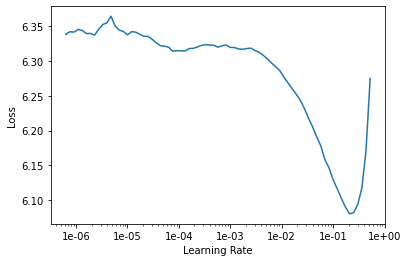

In [7]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
lr = 1e-2

In [8]:
learn.unfreeze()
learn.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.265067,4.201780,0.285960,26:34
1,4.209168,4.140304,0.290293,26:39
2,4.029873,3.977576,0.305852,26:35
3,3.895399,3.817662,0.322576,26:43
4,3.748775,3.761241,0.329072,26:39


In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

Guardamos el modelo

In [0]:
learn.save('fine_tuned_1')

In [0]:
!cp /content/data/imdb/models/fine_tuned_1.pth {drive_folder}

In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
!cp /content/data/imdb/models/fine_tuned_enc.pth {drive_folder}

In [13]:
!ls /content/data/imdb/models

fine_tuned_1.pth  fine_tuned_enc.pth  fit_head.pth


Entrenamos una segunda tanda

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash
#from google.colab import drive
#drive.mount('/content/drive')
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *

Updating fastai...
Done.


In [3]:
path = untar_data(URLs.IMDB)

In [4]:
bs=48

data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

data_lm.save('data_lm.pkl')

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/06\ NLP\ -\ clasificacion'
!mkdir /content/data/imdb/models
!cp {drive_folder}/fine_tuned_1.pth /content/data/imdb/models

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fine_tuned_1');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


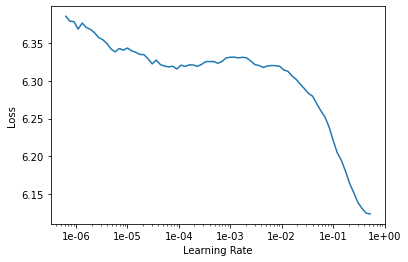

In [7]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
lr = 1e-2

In [9]:
learn.unfreeze()
learn.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.085239,4.019376,0.303363,1:30:07
1,4.103806,4.038305,0.299695,1:30:43
2,3.941566,3.921910,0.310345,1:29:44
3,3.811636,3.781397,0.324798,1:29:49
4,3.695034,3.730313,0.330730,1:29:47


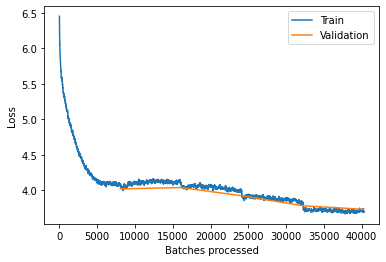

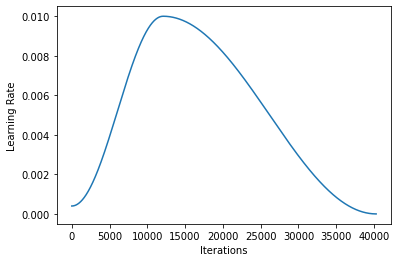

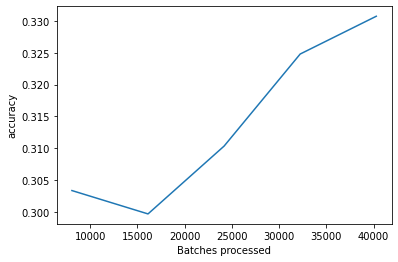

In [10]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

In [0]:
learn.save('fine_tuned_2')
!cp /content/data/imdb/models/fine_tuned_2.pth {drive_folder}
learn.save_encoder('fine_tuned_enc')
!cp /content/data/imdb/models/fine_tuned_enc.pth {drive_folder}

Veamos cómo de bueno es nuestro modelo del lenguaje

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [13]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because the main character played by Bob Steele was a great actor . He was great as the main character , and Wendy J. was not the most attractive . She plays a good girl
I liked this movie because it was a rich one . It was not a depressing journey of life , but it was about the fact that Bollywood is really flawed . It is great to see a movie that completely sucks


### Clasificador

Reiniciamo el kernell y volvemos a ejecutar el código necesario

Prerequisitos

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
#from google.colab import drive
#drive.mount('/content/drive')
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *

Updating fastai...
Done.


Descarga del dataset

In [2]:
path = untar_data(URLs.IMDB)

Se descarga el encoder

In [0]:
drive_folder = '/content/drive/My\ Drive/Colab\ Notebooks/Curso\ fastai/06\ NLP\ -\ clasificacion'
!mkdir /content/data/imdb/models
!cp {drive_folder}/fine_tuned_enc.pth /content/data/imdb/models

#### Se crea el dataset

Primero se crea el del modelo del lenguaje

In [5]:
bs=48

data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

* Como todos los textos están en carpetas se usa `TextList.from_folder` en vez de `TextList.from_csv`. Además, le pasamos el vocabulario del modelo del lenguaje entrenado anteriormente
* Se usa `filter_by_folder` para indicar los archivos de test 
* Con `label_from_folder` indicamos dónde están las etiquetas
* Por último creamos el `DataBunch` con `databunch`

In [6]:
bs = bs

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg', 'pos'])
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

Como crear este dataset ha llevado mucho tiempo, podemos guardarlo y cargarlo en el futuro mediante el comando

`data_clas = load_data(path, 'data_clas.pkl', bs=bs)`

In [7]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * * xxmaj attention xxmaj spoilers * * \n \n xxmaj first of all , let me say that xxmaj rob xxmaj roy is one of the best films of the 90 's . xxmaj it was an amazing achievement for all those involved , especially the acting of xxmaj liam xxmaj neeson , xxmaj jessica xxmaj lange , xxmaj john xxmaj hurt , xxmaj brian xxmaj cox",pos
"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" xxmaj kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out",pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n \n xxmaj so , i approached watching this the way i 'd approach doing homework . \n \n i",pos


#### Entrenamiento

Se crea el modelo

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


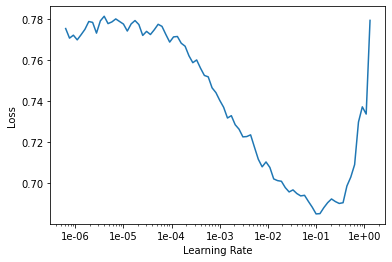

In [9]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [11]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.548146,0.506643,0.752480,10:47


In [0]:
learn.save('first')

Descongelamos las dos últimas capas y entrenamos

In [13]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.446784,0.375302,0.829440,10:22


In [0]:
learn.save('second')

Descongelamos las tres últimas capas y entrenamos

In [15]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.383194,0.334546,0.849840,16:27


In [0]:
learn.save('third')

Descongelamos todas las capas y entrenamos

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.344986,0.319601,0.858200,19:20
1,0.330168,0.317418,0.861400,18:25


Probamos el clasificados

In [18]:
learn.predict("I really loved that movie, it was awesome!")

(Category tensor(1), tensor(1), tensor([0.1433, 0.8567]))